# Boosting für Machine Learning

Wir beschäftigen uns mit den grundlegenden Varianten des sogenannten _Boostings_.
Dabei legen wir unser Augenmerk auf Boosting für die Klassifikation.
Insbesondere klassifizieren wir Reden von deutschen Politikern, d.h. aus einem gegebenen Redetext ermitteln wir wer diese Rede hielt.
(Diese Problemstellung ist auch Thema im Abschnitt [Natural Language Processing](https://www.youtube.com/watch?v=GmLsb-o7hvM) dieses [Bootcamps](https://www.codecentric.de/kuenstliche-intelligenz/).)

Boosting dreht sich um die folgende Frage.

_Angenommen für unser Problem steht ein schlechter Klassifikator K zur Verfügung._
_Wie können wir aus K einen guten Klassifikator K' erzeugen?_

Unter einem schlechten Klassifikator verstehen wir einen Klassifikator mit schlechter Vorhersagekraft, d.h. er macht viele falsche Vorhersagen.
(Die Theorie erlaubt sogar so viele Fehler, dass die Kraft nur wenig besser als zufälliges Raten ist!)
Der gute Klassifikator K' wird keine abgewandelte Form von K sein, sondern K' besteht aus mehreren geschickt kombinierten Instanzen von K.
Daher bezeichnet man K' auch als _Ensemble_.

Ensembles lassen sich aus unterschiedlichen Typen von Klassifikatoren zusammenstellen.
Hier beschränken wir uns auf den Fall, dass K ein einfacher [Entscheidungsbaum](https://en.wikipedia.org/wiki/Decision_tree_learning) ist.
Eine Vorhersage des Ensembles K' ergibt sich aus den individuellen Vorhersagen der beteiligten Entscheidungsbäume.

Im Rest des Artikels stellen wir verschiedene Boosting-Ansätze je kurz in allgemeiner Form vor, orientieren jedoch nähere Erläuterungen an der Implementierung mit Entscheidungsbäumen.
Bemerke, dass wir kein Tuning der Implementierung durchführen, sondern uns vielmehr darauf konzentrieren, die Unterschiede der Verfahren zu beleuchten.

## Daten laden

Werfen wir zuerst einen Blick auf die Daten.
Wir verwenden den von Barbaresi und Adrien bereitgestellten Datensatz [1], der unter http://purl.org/corpus/german-speeches ist.

[1] Barbaresi, Adrien (2018). "A corpus of German political speeches from the 21st century", Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

Vorab ein Einblick in wenige zufällig ausgewählte Reden.
(Hier wie auch unten lagern wir Code aus, welcher nicht zu unserem Lernziel beiträgt, und binden ihn per `%run` ein.
Hier sorgen wir dafür, dass der Datendatz nur einmal aus dem Netz gezogen werden muss.)
Die Variable `df` ist ein `DataFrame` aus der [Pandas](https://pandas.pydata.org/)-Bibliothek;
Im Wesentlichen werden in `df` tabellarische Daten gespeichert.

In [1]:
%run includes/define_load_data_functions.ipynb

df = load_cached_speeches_or_download() # das Laden kann ein wenig dauern, also nicht wundern, wenn es nicht direkt weiter geht

display(df.sample(n=5)) # `sample` wählt eine zufällige Teilmenge aus

,person,speech
1164,Angela Merkel,Wer feiert eigentlich nicht gerne Geburtstag –...
2338,Monika Grütters,"""Die gemeinsame Welt verstehen, so wie sie dem..."
1356,Angela Merkel,Sie haben für Ihren diesjährigen Unternehmerta...
824,Christina Weiss,"Als vor zwölf Jahren bekannt wurde, dass die m..."
1432,Thomas de Maizière,Sperrfrist: Redebeginn\n\nmeine sehr verehrten...


Wir betrachten die Spalte `person` und stellen fest, dass Angela Merkel mit der weitaus stärksten Anzahl von Reden vertreten ist.

In [2]:
speech_counts = df.person.value_counts()

display(speech_counts)

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Um im restlichen Notebook auf ausgewogenen Daten zu arbeiten, beschränken wir uns auf die binäre Klassifikation und unterscheiden nur zwischen zwei Klassen von Personen, nämlich _Angela Merkel_ und _Andere_.
Dazu vernachlässigen wir zuerst alle Personen, die mit nur wenigen Reden vertreten sind.

In [3]:
MIN_NUM_SPEECHES = 100
belowThreshold = lambda name: speech_counts[name] < MIN_NUM_SPEECHES

dropped = filter(belowThreshold, df.person.tolist())
df.drop(df[df.person.isin(dropped)].index, inplace=True)

display(df.person.value_counts())

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

Abschließend fassen wir alle Personen außer Angela Merkel zur Klasse _Andere_ zusammen.

In [4]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'

display(df.person.value_counts())

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

## Daten vorverarbeiten

Es folgt die Vorverarbeitung der Reden mit Hilfe der Natural-Language-Processing-Bibliothek [spaCy](https://spacy.io/).
Wir zerlegen jede Rede in ihre (durch Whitespace getrennten) Bestandteile, die sogenannten _Tokens_.
Im selben Zuge entfernen wir Tokens mit geringer Information, wie z.B. Interpunktion und Stoppwörter ("und", "der", "die", "das", ...).
Außerdem überführen wir jedes Token in seine Grundform, das sogenannte _Lemma_ (z.B. "angekündigt" -> "ankündigen").

Zuerst initialisieren wir spaCy.
Dafür laden wir das Modell `de_core_news_sm` für die deutsche Sprache, markieren Stopwörter und deaktivieren nicht benötigte Teile der Verarbeitungspipeline.
In der Pipeline verbleiben die Schritte zur Tokenisierung und Lemmatisierung.

Das Laden des nächsten Blockes kann ein wenig dauern, also nicht wundern, wenn es nicht direkt weiter geht.

In [5]:
import spacy

nlp = spacy.load("de_core_news_sm")

for stopword in nlp.Defaults.stop_words:
    # berücksichtige die wichtigsten Varianten von Groß-/Kleinschreibung
    for w in (stopword.lower(), stopword.lower().capitalize(), stopword.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True
        
_ = nlp.disable_pipes("tagger", "parser", "ner")

Nach der Verarbeitung einer Rede durch spaCy filtern wir Stopwörter und verwerfen Bestandteile, die nur aus einem Zeichen bestehen (insbesondere Interpunktion).
Schließĺich extrahieren wir Tokens und Lemmata.

In [6]:
def dropSingleCharacters(words):
    return list(filter(lambda word: len(word.text.strip()) > 1, words))

def preprocess(speech):
    document = nlp(speech)
    
    words = [word for word in document if not word.is_stop]
    words = dropSingleCharacters(words)
    
    tokens = [word.text for word in words]
    lemmata = [word.lemma_ for word in words]
    return (tokens, lemmata)

Jetzt können wir die Reden vorverarbeiten.
(Wieder sorgen wir dafür, dass diese Arbeit nur einmal durchgeführt und dann in einem Cache abgelegt wird.)
Die Folgen von Tokens und Lemmata werden dabei dem DataFrame `df` hinzugefügt, aus dem wir wieder ein paar Zeilen betrachten.

In [7]:
%run includes/define_preprocessing.ipynb

df = load_cached_or_preprocess(df.speech)

display(df.head())

,person,speech,tokens,lemmata
0,Andere,"es ist angekündigt worden, man sollte im Beruf...","[angekündigt, Beruf, Schauspieler, Politiker, ...","[ankündigen, berufen, schauspielern, Politiker..."
2,Andere,Frage (Peter Hahne): Bevor wir uns über den Au...,"[Frage, Peter, Hahne, Bevor, Aufbau, Ost, Arbe...","[Frage, Peter, Hahn, bevor, Aufbau, Ost, Arbei..."
3,Andere,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...","[Satz, Herr, Dr., Bernotat, aufgeschrieben, Ar...","[Satz, Herr, Dr., Bernotat, aufschreiben, Argu..."
4,Andere,diese Jahresversammlung der Hochschulrektorenk...,"[Jahresversammlung, Hochschulrektorenkonferenz...","[Jahresversammlung, Hochschulrektorenkonferenz..."
5,Andere,"ich habe nie einen Hehl daraus gemacht, dass i...","[Hehl, Stadt, komme, Amtszeit, Gast, gefühlt, ...","[Hehl, Stadt, kommen, Amtszeit, gasen, fühlen,..."


Für jede Rede R überführen wir nun die Folge von Lemmata von R in das "Histogramm" der Lemmahäufigkeiten von R.
Bemerke, dass wir dabei die Reihenfolge der Worte vergessen.
(Man nennt solch eine vereinfachte Darstellung einer Wortfolge auch _bag of words_, um das Abhandensein von zeitlicher Information zu betonen.)

Für die Berechnung der Lemmahäufigkeiten bilden wir zunächst einen Gesamtindex aller in allen Reden vorkommenden Lemmata.
Dann schauen wir uns ein paar Lemmata und die gewonnene Darstellung einer Rede im Detail an.

In [8]:
from collections import Counter

def compute_index(feature_vectors):
    sets = [set(vector) for vector in feature_vectors]
    union = set.union(*sets)
    idx_2_feature = [feature for (index, feature) in enumerate(union)]
    feature_2_idx = {feature:index for (index, feature) in enumerate(union)}
    return (idx_2_feature, feature_2_idx)

def count(feature_vectors, index):
    return feature_vectors.apply(lambda vector: {index[feature]:count for (feature, count) in Counter(vector).items()})

(lemmata, lemma_index) = compute_index(df["lemmata"])
df["lemma_counts"] = count(df["lemmata"], lemma_index)

display(lemmata[0:10])
display(df.iloc[11]) # In lemma_counts ist jedes Lemma durch eine Nummer repräsentiert.

['Blutproben',
 'Schulterzucken',
 'Kulturwandel',
 'Energiesicherheit',
 'Ludus',
 'Infektionsrisiken',
 'Ventures',
 'kuwaitischen',
 'Kommunismus',
 'Mittelstädt']

person                                                     Andere
speech          Wenn es um die Geschichte und um Erinnerung ge...
tokens          [Geschichte, Erinnerung, Zahlen, guten, Ruf, Z...
lemmata         [Geschichte, Erinnerung, Zahl, gut, rufen, Zah...
lemma_counts    {80677: 3, 56766: 5, 29896: 4, 97787: 1, 11979...
Name: 15, dtype: object

(Bemerke, dass einige der gewonnenen Lemmata nicht "perfekt" sind.
Sie enthalten etwa Bindestriche oder liegen in gebeugter Form vor.
Hier wird die Unschärfe der Sprache und ihrer Verarbeitung sichtbar.
Insbesondere geschieht Lemmatisierung in spaCy nicht durch Anwendung eines Regelwerks, sondern mit Hilfe von neuronalen Netzen, die natürlich nicht in allen Fällen korrekte Ergebnisse erzielen.)

## Training

Bis hier haben wir aus den Reden die für das Modell-Training benötigten statistischen Informationen, die Lemmahäufigkeiten, extrahiert.
Zum Start des Trainings fehlt nun nur noch die Konvertierung in das benötigte Eingabedatenformat für die ML-Bibliothek [scikit-learn](https://scikit-learn.org/stable/), mit der wir in diesem Notebook arbeiten.

Die eingegebenen Trainingdaten bestehen aus einer Sammlung von sogenannten _Labels_ (eins pro Rede) und sogenannten _Featurevektoren_ (ebenfalls einer pro Rede).
In unserem Fall gibt das Label einer Rede R an, welche Person die Rede R hielt (_Angela Merkel_ oder _Andere_).
Der Feature-Vektor von R kodiert das Histogramm der Lemmahäufigkeiten von R (haben wir oben bereits berechnet).

Für die Eingabe in die Algorithmen von scikit-learn werden alle Labels (kodiert als Nullen und Einsen) in einem Vektor zusammengefasst.

In [9]:
categories = df["person"].astype("category")
labels = categories.cat.codes

display(labels[0:10]) # zeige die ersten zehn Labels

0     0
2     0
3     0
4     0
5     0
9     0
10    0
11    0
12    0
13    0
dtype: int8

Analog werden alle Featurevektoren zu einer Matrix zusammengefasst (in gleicher Reihenfolge zum Labelvektor).
Natürlich müssen alle Featurevektoren der Matrix die gleiche Länge haben;
Die Funktion `dict_to_sparse` erledigt die nötige Konvertierung.

In [10]:
import scipy.sparse as sparse
import itertools

def dict_to_sparse(lemma_counts, vocabulary_size):
    idx_and_count = [(idx, counts[idx]) for counts in lemma_counts for idx in counts]
    idx, count = zip(*idx_and_count)
    
    num_lemmata = [len(counts) for counts in lemma_counts]
    
    row_pointers = list(itertools.accumulate([0] + num_lemmata))
    return sparse.csr_matrix((count, idx, row_pointers), shape=(len(lemma_counts), vocabulary_size))

feature_matrix = dict_to_sparse(df["lemma_counts"], len(lemma_index))

(Insbesondere gibt `dict_to_sparse` eine sogenannte _dünn besetzte Matrix_ aus, in der Einträge mit Wert Null nicht explizit gespeichert werden.
Warum?
In einer gegebenen Rede erscheinen bei Weitem nicht alle möglichen Lemmata, folglich enthält jeder Featurevektor viele Nullen.
Daher ist auch die Matrix "voller" Nullen.
Also sparen wir bei Verzicht auf eine explizite Darstellung viel Speicherplatz.
Im Wesentlichen werden in einer Implementierung Blöcke aus Nullen nicht gespeichert und die jeweils nächsten "Eins-Zellen" verzeigert.)

<img src="images/sparseMatrix.jpg" width="50%">


### Der schwache Klassifizierer

Möge das Training beginnen.
Wir erinnern uns, dass wir Ensembles von schwachen Klassifizierern erstellen möchten.
Als schwachen Klassifizierer wählen wir einen sogenannten _Decision Stump_, d.h. einen Entscheidungsbaum der Tiefe 1.

In [11]:
from sklearn.tree import DecisionTreeClassifier

DECISION_TREE_DEPTH=1

# die Generatorfunktion benötigen wir für später
def generate_decision_stump():
    return DecisionTreeClassifier(max_depth=DECISION_TREE_DEPTH)

Zum Warmwerden trainieren wir zunächst einen einzelnen Stump.
Damit wir die Performance verlässich evaluieren können, führen wir das Experiment nicht nur einmal durch, sondern wiederholen es und mitteln die Ergebnisse.
Dafür verwenden wir die folgenden Hilfsfunktionen, welche wir nach Vorstellung des Codes näher erläutern.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# implementiert das eigentliche Training
def train_and_test(classifier, data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, 
        labels,
        test_size=test_size,
        stratify=labels)
    
    # training
    classifier.fit(train_data, train_labels)
    
    # test
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (accuracy, confusion)

# wiederholt und sammelt Klassifikatoren und ihre Ergebnisse
def train_and_test_repeated(classifier_generator, data, labels, test_size, repetitions):
    classifiers = []
    accuracies = []
    confusion_matrices = []
    
    for i in range(repetitions):
        display("Wiederholung " + str(i))
        
        # hier geschieht das eigentliche Training
        classifier = classifier_generator()
        (accuracy, confusion) = train_and_test(classifier, data, labels, test_size)
        
        classifiers.append(classifier)
        accuracies.append(accuracy)
        confusion_matrices.append(confusion)

    return (classifiers, accuracies, confusion_matrices)

In `train_and_test_with` zerlegen wir die Eingabedaten in Trainingdaten und Testdaten, und zwar in einem frei wählbaren Verhältnis (üblich ist zum Beispiel das Verhältnis "train/test = 70/30").
Nur die Trainingsdaten werden für das tatsächliche Training verwendet.
Mit Hilfe der Testdaten wird die Performance des fertig trainierten Stumps evaluiert.

Die _Accuracy_ zeigt uns wie viele Testdatensätze korrekt klassifiziert wurden.
Die sogenannte _Confusion Matrix_ schlüsselt die korrekten und falschen Klassifizierungen auf (in der i-ten Zeile und j-ten Spalte steht wie viele Reden von "i" als Reden von "j" klassifiziert wurden).

#### Los geht's

Für das Training des einzelnen Decision Stumps wählen wir eine Zerlegung von 70/30 und führen 20 Wiederholungen durch.
Wir sehen, dass im Mittel nicht einmal 80% der Testreden korrekt klassifiziert werden, wobei mehr Reden von Angela Merkel falsch klassifiziert werden (deutlich über 30%) als Reden von anderen (ca. 10%).

'Wiederholung 0'

'Wiederholung 1'

'Wiederholung 2'

'Wiederholung 3'

'Wiederholung 4'

'Wiederholung 5'

'Wiederholung 6'

'Wiederholung 7'

'Wiederholung 8'

'Wiederholung 9'

'Wiederholung 10'

'Wiederholung 11'

'Wiederholung 12'

'Wiederholung 13'

'Wiederholung 14'

'Wiederholung 15'

'Wiederholung 16'

'Wiederholung 17'

'Wiederholung 18'

'Wiederholung 19'

0.7676978417266186

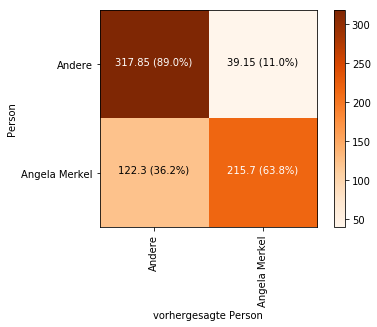

In [13]:
%run includes/define_plot_functions.ipynb

TRAIN_TEST_RATIO = 0.3
REPETITIONS = 20

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_decision_stump, 
    data=feature_matrix,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

Wir werfen einen Blick in die Blackbox und betrachten einen der trainierten Decision Stumps genauer.
Interessant ist insbesondere die erste Zeile des Wurzelknotens.
Die Häufigkeit genau eines Lemmas bestimmt welchem der beiden Blätter eine gegebene Rede zugeordnet wird.
Jedes Blatt klassifiziert alle ihm zugeordneten Reden mit der gleichen Person, wie die jeweils letzte Zeile zeigt.

(Der Wert _samples_ zeigt wie viele Reden dem jeweiligen Knoten zugeordnet werden.
Für die einem Knoten zugeordneten Reden nennt der Wert _value_ die berechnete Redner-Verteilung:
Die beiden Werte für _Andere_ bzw. _Angela Merkel_ summieren sich zu Eins.)

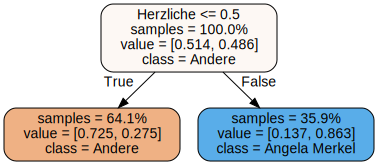

In [14]:
display_decision_tree(classifiers[0])

Beachte, dass dieser Stump eine Schnittebene durch einen n-dimensionalen Raum darstellt, wobei n die Anzahl der Lemmata ist.

In [15]:
n = len(lemma_index)
display(n)

98139

Eine eingängigere Visualisierung, beispielsweise in einer Fläche, ist also schwierig möglich. :-)

### Bagging
Bisher haben wir mehrere Stumps unabhängig voneinander trainiert und anschließend ihre mittlere Performance betrachtet.
Diese Idee verfolgt auch das sogenannte _Bagging_ (kurz für _bootstrap aggregating_).
Bagging erstellt ein Ensemble von unabhängigen Stumps, wendet die Mittelung jedoch schon früher an, nämlich zur Klassifizierung einer Rede.

Da die Berechnungen der individuellen Stumps nicht voneinander abhängen, können wir mit Hilfe von allen zur Verfügung stehenden CPUs parallelisieren.

<img src="images/baggingTrain.jpg" width="50%">

Wenn die Person für Rede R vorhergesagt werden soll, kombiniert das Bagging-Ensemble die Berechnungen der individuellen Stumps zu einer einzigen Vorhersage.
Dabei wird nicht einfach nur unter den individuellen Vorhersagen abgestimmt, sondern bereits die individuellen Vorhersagewahrscheinlichkeiten beider Personen für R gemittelt und dieses Mittel zur finalen Vorhersage verwendet.

<img src="images/baggingPredict.jpg" width="50%">

Da die Berechnungen aller Decision Stumps eines Baggings unabhängig voneinander sind, können wir mit Hilfe aller zur Verfügung stehenden CPUs parallelisieren.

'Wiederholung 0'

'Wiederholung 1'

'Wiederholung 2'

'Wiederholung 3'

'Wiederholung 4'

'Wiederholung 5'

'Wiederholung 6'

'Wiederholung 7'

'Wiederholung 8'

'Wiederholung 9'

'Wiederholung 10'

'Wiederholung 11'

'Wiederholung 12'

'Wiederholung 13'

'Wiederholung 14'

'Wiederholung 15'

'Wiederholung 16'

'Wiederholung 17'

'Wiederholung 18'

'Wiederholung 19'

0.7810071942446044

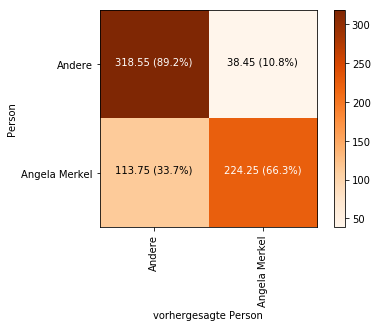

In [16]:
from sklearn.ensemble import BaggingClassifier

NUM_BASE_ESTIMATORS = 20
ALL_CORES = -1

def generate_bagging_classifier():
    return BaggingClassifier(base_estimator=generate_decision_stump(),
                             n_estimators=NUM_BASE_ESTIMATORS,
                             n_jobs=ALL_CORES)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_bagging_classifier, 
    data=feature_matrix,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

Bemerke, dass wir keine Verbesserung der Performance gegenüber unserem Experiment aus dem vorangehenden Abschnitt erwarten können.
Der Grund ist, dass jeder einzelne Bagging-Klassifizierer im Wesentlichen unsere Mittelung des vorherigen Abschnitts nachstellt.
Die Wiederholung des Baggings und die anschließende Mittelung über die Performances verändert die einzelnen Ergebnisse nicht entscheidend.

# Boosting

Die Performance des schwachen Decision Stumps und des naiven Baggings können wir sicherlich verbessern.
Erfreulich wird sein, mit welch einfachen Mitteln das gelingt!

## AdaBoost

[AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) erstellt ebenfalls ein Ensemble von schwachen Klassifizierern.
Die Klassifizierer sind im Gegensatz zum Bagging aber nicht unabhängig voneinander.
Erstellt wird nämlich eine _Folge_ von Klassifizierern, wobei sich die Performance eines Klassifizierers auf das Training des nächsten auswirkt.
Ziel ist es, Schwächen des Klassifizierers zu identifizieren, diese Schwächen in folgenden Trainings zu kompensieren und schließlich stark aus dem gesamten Trainingsplan hervorzugehen.

Wie trainiert AdaBoost in unserem Anwendungsfall?
Für jeden fertig trainierten Stump T werden alle falsch klassifizierten Reden identifiziert.
Diese Reden stellen offenbar "schwierige" Eingaben für T dar - sonst würde T sie ja der korrekten Person zuordnen.
Solch schwierige Reden werden mit erhöhter Wahrscheinlichkeit ausgewählt, wenn eine zufällige Trainingsmenge für den nächsten Stump gezogen wird.
Das nächste Training ist also mit einer "schwierigeren" Eingabe konfrontiert, welche mehr Informationen über schwer einzuordnende Reden enthält.
(Tatsächlich wird in der Implementierung die Auswahlwahrscheinlichkeit _korrekt_ von T klassifizierter Reden _verringert_.
Der Verringerungsfaktor ergibt sich aus dem _Fehler von S_, der Wahrscheinlichkeit eine zufällig gemäß aktueller Verteilung gezogene Rede falsch zu klassifizieren, welcher oft mit &epsilon;<sub>S</sub> bezeichnet wird.)

<img src="images/adaboostTrain.jpg" width="50%">

Wie klassifiziert AdaBoost?
Jeder Stump des Ensembles beeinflusst die Gesamtvorhersage mit unterschiedlichem Gewicht.
Das Gewicht für Stump T ergibt sich aus dem Fehler &epsilon;<sub>S</sub>:
Je kleiner der Fehler, umso größer ist der Einfluss von S.
Wie beim Bagging wird nicht bloß unter allen beteiligten Stumps abgestimmt, sondern die individuellen Vorhersagewahrscheinlichkeiten gemittelt.

<img src="images/adaboostPredict.jpg" width="50%">

Das Ergebnis unseres Experiments:
Im Schnitt erreicht ein AdaBoost-Klassifier eine Genauigkeit von über 90% (mit Bagging erreichten wir nur unter 80%).
Die Anteile der Fehlklassifizierungen fielen in den einstelligen Prozentbereich.

'Wiederholung 0'

'Wiederholung 1'

'Wiederholung 2'

'Wiederholung 3'

'Wiederholung 4'

'Wiederholung 5'

'Wiederholung 6'

'Wiederholung 7'

'Wiederholung 8'

'Wiederholung 9'

'Wiederholung 10'

'Wiederholung 11'

'Wiederholung 12'

'Wiederholung 13'

'Wiederholung 14'

'Wiederholung 15'

'Wiederholung 16'

'Wiederholung 17'

'Wiederholung 18'

'Wiederholung 19'

0.9298561151079137

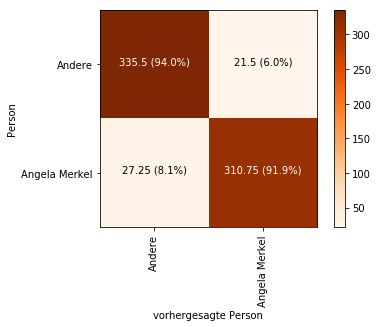

In [17]:
from sklearn.ensemble import AdaBoostClassifier

# keine parallele Berechnung der Sequenz möglich
def generate_adaboost_classifier():
    return AdaBoostClassifier(base_estimator=generate_decision_stump(),
                              n_estimators=NUM_BASE_ESTIMATORS)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_adaboost_classifier, 
    data=feature_matrix,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

## Gradient Boosting

Gradient Boosting ist ein weiterer Ensemble-Ansatz.
Wie für AdaBoost wird die initiale Trainingsmenge zufällig erstellt und für sie ein Klassifizierer trainiert.
Anders als bei AdaBoost werden jedoch keine weiteren Klassifizierer traininert.
Stattdessen wird der Fehler des initialen Klassifizierers in den folgenden Schritten _numerisch_ ausgeglichen, indem eine Folge von Regressionsbäumen (Stumps) berechnet wird.
(Gradient Boosting ist keine Verallgemeinerung von AdaBoost.)

Wie also trainiert Gradient Boosting den nächsten Stump T der Folge?
Das Ziel ist die Korrektur der Fehlklassifizierungen des gesamten bisher erstellten "aktuellen" Teil-Ensembles E, d.h. der Abweichungen zwischen den aktuellen Vorhersagen von E und den tatsächlichen RednerInnen.
Die Gesamtheit aller aktuellen Abweichungen wird mit einer sogenannten _Loss-Funktion L_ bewertet.
Der Loss ist gleich Null, wenn alle Reden korrekt klassifiziert werden, und größer als Null sonst.
Die Funktion L wird differenzierbar gewählt, daher können wir die Steigung von L in jedem Punkt berechnen - inklusive der Richtung des steilsten Abstiegs!
(Z.B. ist der mittlere quadratische Fehler über alle Reden differenzierbar.)
Uns interessiert die Richtung des steilsten Abstiegs von L aus dem Punkt des aktuellen Ensembles E.
Verändern wir die Vorhersage von E in diese Richtung, so können wir den Loss verringern und folglich eine verlässlichere Vorhersage erhalten.

Wie weit "gehen" wir in diese Richtung?
Die Schrittweite s sollten wir so optimieren, dass wir am niedrigsten Punkt landen.
Achtung:
In der Richtung des steilsten Abstiegs liegt im Allgemeinen _nicht_ der Nullpunkt von L und es geht auch nicht ausschließlich "bergab".
Daher ist s nicht beliebig wählbar.

Dieser Abstieg gemäß Gradienten ist namensgebend für das Verfahren.
Im folgenden Bild sehen wir die Höhenlinien von L, den initialen Klassifikator, die Folge der korrigierenden Regressions-Stumps und wie die Vorhersagen schrittweise so angepasst werden, dass der Loss L kleiner wird (Erinnerung: Im Nullpunkt von L werden alle Reden korrekt klassifiziert).

<img src="images/gradientboostingTrain.jpg" width="50%">

Bisher haben wir ausschließlich die ideale Theorie betrachtet.
Die Praxis legt uns jedoch einige Restriktionen auf.
In der tatsächlichen Implementierung können wir nämlich aus dem gemachten Schritt "bergab", genauer aus dem resultierenden Punkt, nicht einfach einen Stump T erzeugen, der diesen Schritt nachbildet.
Daher wird in der Tat gar kein solcher "numerischer" Schritt vollzogen, sondern der nächste Stump T auf dem Gradienten von L im Punkt E trainiert (dieser Gradient wir auch Pseudo-Residual genannt).
Danach können wir T zum bisherigen Ensemble "einfach addieren".

Bemerke, dass zur Vermeidung von Overfitting die Komplexität des nächsten Stumps T im Allgemeinen beschränkt ist - z.B. indem die Anzahl der Knoten nicht beliebig groß sein darf.
Daher kann nicht jede Rede der Trainingsmenge explizit berücksichtigt werden und T bildet den beabsichtigten Schritt "bergab" nicht exakt nach.
So kann sich z.B. eine Abweichung von der beabsichtigten Richtung ergeben.

Folglich führt auch eine für den aktuellen Gradienten optimierte Schrittweite s nicht unbedingt zu einem optimalen Stump S.
Daher wird s gar nicht optimiert, sondern verringert sich für jeden neuen Stump nach einem fest vorgegebenen Schema (im folgenden Beispiel haben wir die sogenannte _Learning Rate_ auf 0.6 gesetzt).

Schließlich erhalten wir das nächste Teil-Ensemble " E' = E + sT " und wiederholen mit E'.
Die Vorhersage des finalen Ensembles besteht also im Wesentlichen aus einer gewichteten Summe über alle Stumps.

<img src="images/gradientboostingPredict.jpg" width="50%">

Abschließend sei bemerkt, dass alternativ zum gewohnten Training des ersten (Klassifikations-)Stumps der Folge dieser auch zufällig oder gar beliebig gewählt werden kann, denn der Ansatz der schrittweisen Fehlerkorrektur funktioniert auch in diesen Fällen.

Mit Gradient Boosting können wir die Genauigkeit weiter auf ca. 94% heben, wofür wir allerdings ein größeres Ensemble als bisher benötigen.

'Wiederholung 0'

'Wiederholung 1'

'Wiederholung 2'

'Wiederholung 3'

'Wiederholung 4'

'Wiederholung 5'

'Wiederholung 6'

'Wiederholung 7'

'Wiederholung 8'

'Wiederholung 9'

'Wiederholung 10'

'Wiederholung 11'

'Wiederholung 12'

'Wiederholung 13'

'Wiederholung 14'

'Wiederholung 15'

'Wiederholung 16'

'Wiederholung 17'

'Wiederholung 18'

'Wiederholung 19'

0.9405035971223021

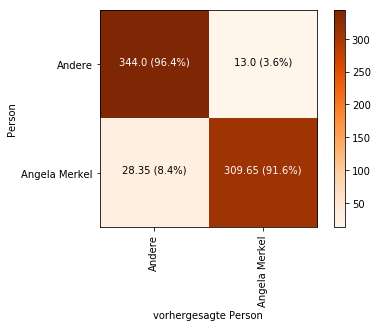

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

STEP_SIZE=0.6

# Ein GradientBoostingClassifier verwendet standardmäßig Entscheidungsbäume.
# Wir müssen noch die Höhe
def generate_gradient_boosting_classifier():
    return GradientBoostingClassifier(max_depth=DECISION_TREE_DEPTH,
                                      n_estimators=NUM_BASE_ESTIMATORS*2,
                                      learning_rate=STEP_SIZE)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_gradient_boosting_classifier, 
    data=feature_matrix,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

## XGBoost

XGBoost stellt im Wesentlichen eine Verbesserung von herkömmlichem Gradient Boosting dar.
Beispielsweise erlaubt die Verwendung von Gradienten zweiter Ordnung eine bessere Bestimmung der Abstiegsrichtung und -weite.
Weiterhin werden Methoden zur besseren Vermeidung von Overfitting implementiert.
Zudem arbeitet XGBoost deutlich schneller und parallelisiert die Berechnung von sehr großen Entscheidungsbäumen.
Für einen detaillierteren Einstieg in XGBoost siehe das [codecentric.AI-Video](https://www.youtube.com/watch?v=xXZeVKP74ao) zum Thema.